In [19]:
import torch_geometric

import numpy as np
import pandas as pd
import torch
from torch.nn import Linear, LayerNorm, ReLU, Dropout
import torch.nn.functional as F
from torch_geometric.nn import ChebConv, NNConv, DeepGCNLayer, GATConv, DenseGCNConv, GCNConv, GraphConv
from torch_geometric.data import Data, DataLoader
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
import scipy.sparse as sp
from torch_geometric_temporal.nn.recurrent import EvolveGCNO, EvolveGCNH

import warnings
warnings.filterwarnings("ignore")

# ref: https://medium.com/stanford-cs224w/fraud-detection-with-gat-edac49bda1a0

#### dataset

In [20]:
# import data 
df_features = pd.read_csv('data/elliptic_txs_features.csv', header=None)
df_edges = pd.read_csv("data/elliptic_txs_edgelist.csv")
df_classes =  pd.read_csv("data/elliptic_txs_classes.csv")

df_classes['class'] = df_classes['class'].map({'unknown': 2, '1':1, '2':0})

# merging dataframes
df_merge = df_features.merge(df_classes, how='left', right_on="txId", left_on=0)
df_merge.drop(0, axis=1, inplace=True)

# check if there are duplicate txId
# print("Number of duplicate txId: ", df_merge.duplicated(subset=['txId']).sum())

# rename column 0 to time_step
df_merge.rename(columns={1: 'time_step'}, inplace=True)
# display(df_merge.head())
# display(df_edges.shape)
edges = df_edges.copy()

# Setup trans ID to node ID mapping
nodes = df_merge['txId'].values
map_id = {j:i for i,j in enumerate(nodes)} # mapping nodes to indexes

# Map transction IDs to node Ids
edges.txId1 = edges.txId1.map(map_id) #get nodes idx1 from edges list and filtered data
edges.txId2 = edges.txId2.map(map_id)
edges = edges.astype(int)

# Reformat and convert to tensor
edge_index = np.array(edges.values).T 
edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous()

# print("shape of edge index is {}".format(edge_index.shape))
node_features = df_merge.drop(['txId'], axis=1).copy()
# print("unique=",node_features["class"].unique())

# Retain known vs unknown IDs
all_classified_idx = node_features['class'].loc[node_features['class']!=2].index # filter on known labels
all_unclassified_idx = node_features['class'].loc[node_features['class']==2].index
all_classified_illicit_idx = node_features['class'].loc[node_features['class']==1].index # filter on illicit labels
all_classified_licit_idx = node_features['class'].loc[node_features['class']==0].index # filter on licit labels

# node_features = node_features.drop(columns=[0, 1, 'class'])
# display(node_features.head())
train_classified_idx = node_features.loc[(node_features['time_step'] <= 34) & (node_features['class'] != 2)].index
test_classified_idx = node_features.loc[(node_features['time_step'] > 34) & (node_features['class'] != 2)].index
# print("train_classified_idx.shape=",train_classified_idx.shape)
# print("test_classified_idx.shape=",test_classified_idx.shape)
# node_features.drop(columns=['time_step'], inplace=True)
temp_node_features = node_features.copy()
node_features.drop(columns=['class'], inplace=True)

# Convert to tensor
node_features_t = torch.tensor(np.array(node_features.values, dtype=np.double), dtype=torch.double)
# Define labels
labels = df_merge['class'].values

#create weights tensor with same shape of edge_index
weights = torch.tensor([1]* edge_index.shape[1] , dtype=torch.double) 

# Do train test split on classified_ids
train_idx = train_classified_idx
test_idx = test_classified_idx

# Create pyG dataset
data_graph = Data(x=node_features_t.float(), edge_index=edge_index, edge_attr=weights, 
                               y=torch.tensor(labels, dtype=torch.long))

# Add in the train and valid idx
data_graph.train_idx = train_idx
data_graph.test_idx = test_idx
data_graph

Data(x=[203769, 166], edge_index=[2, 234355], edge_attr=[234355], y=[203769], train_idx=Int64Index([     3,      9,     10,     11,     16,     17,     25,     27,
                29,     30,
            ...
            136232, 136233, 136234, 136236, 136239, 136241, 136243, 136249,
            136250, 136258],
           dtype='int64', length=29894), test_idx=Int64Index([136276, 136277, 136278, 136279, 136280, 136282, 136285, 136287,
            136288, 136291,
            ...
            203727, 203730, 203736, 203740, 203750, 203752, 203754, 203759,
            203763, 203766],
           dtype='int64', length=16670))

# Run

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# EvolveGCN evoleveh_model and evoleveh_training

In [22]:
class EvolveGCNHModel(torch.nn.Module):
    def __init__(self, num_of_nodes, in_channels, num_classes):
        super(EvolveGCNHModel, self).__init__()
        self.gcn = EvolveGCNH(num_of_nodes, in_channels)
        self.fc = torch.nn.Linear(in_channels, num_classes)

    def forward(self, data):
        out = self.gcn(data.x, data.edge_index, data.edge_attr)
        out = out.float()
        out = self.fc(out)
        return out

CLASS_WEIGTHS = [0.7,0.3]

def evolvegcnh_train(evolvegcnh_model, data, optimizer):
    evolvegcnh_model.train()
    data = data.to(device)
    optimizer.zero_grad()
    out = evolvegcnh_model(data)
    weights = torch.tensor(CLASS_WEIGTHS, dtype=torch.float).to(device)
    loss = F.cross_entropy(out[data.train_idx], data.y[data.train_idx], weight=weights)
    loss.backward()
    optimizer.step()
    return loss

def evolvegcnh_test(evolvegcnh_model, data):
    evolvegcnh_model.eval()
    with torch.no_grad():
        data = data.to(device)
        out = evolvegcnh_model(data)
        pred_scores = out[data.test_idx]
        pred = torch.argmax(pred_scores, dim=1)
        y = data.y[data.test_idx]
        acc = accuracy_score(y.cpu(), pred.cpu())
        f1 = f1_score(y.cpu(), pred.cpu())
        precision = precision_score(y.cpu(), pred.cpu())
        recall = recall_score(y.cpu(), pred.cpu())
        return acc, f1, precision, recall

num_of_nodes = data_graph.num_nodes
in_channels = data_graph.num_node_features
evolvegcnh_model = EvolveGCNHModel(num_of_nodes, in_channels, 2).to(device)

num_epochs = 500
lr = 0.001
optimizer = torch.optim.Adam(evolvegcnh_model.parameters(), lr=lr)

best_metric_list = []
max_f1 = 0

for epoch in range(num_epochs+1):
    loss = evolvegcnh_train(evolvegcnh_model, data_graph, optimizer)
    acc, f1, precision, recall = evolvegcnh_test(evolvegcnh_model, data_graph)
    # save metrics list when f1 is max
    if f1 > max_f1:
        max_f1 = f1
        best_metric_list = [acc, f1, precision, recall]
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
        ...
print(f'best: Accuracy: {best_metric_list[0]:.4f}, F1: {best_metric_list[1]:.4f}, Precision: {best_metric_list[2]:.4f}, Recall: {best_metric_list[3]:.4f}')


Epoch: 000, Loss: 16.6600, Accuracy: 0.4744, F1: 0.1776, Precision: 0.0988, Recall: 0.8735
Epoch: 010, Loss: 3.5035, Accuracy: 0.9295, F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch: 020, Loss: 1.3328, Accuracy: 0.9343, F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch: 030, Loss: 0.7009, Accuracy: 0.9320, F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch: 040, Loss: 0.3992, Accuracy: 0.9244, F1: 0.0156, Precision: 0.0505, Recall: 0.0092
Epoch: 050, Loss: 0.4511, Accuracy: 0.9274, F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch: 060, Loss: 0.4350, Accuracy: 0.9314, F1: 0.0305, Precision: 0.1856, Recall: 0.0166
Epoch: 070, Loss: 0.5721, Accuracy: 0.9290, F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch: 080, Loss: 0.6513, Accuracy: 0.7479, F1: 0.1227, Precision: 0.0793, Recall: 0.2715
Epoch: 090, Loss: 0.6517, Accuracy: 0.9349, F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch: 100, Loss: 0.1860, Accuracy: 0.8834, F1: 0.2465, Precision: 0.2124, Recall: 0.2936
Epoch: 11

In [26]:
print(f'best: Accuracy: {best_metric_list[0]:.4f}, F1: {best_metric_list[1]:.4f}, Precision: {best_metric_list[2]:.4f}, Recall: {best_metric_list[3]:.4f}')


best: Accuracy: 0.8995, F1: 0.3705, Precision: 0.3124, Recall: 0.4552


## GCN recovery testing

## EvolveGCN evoleveh_model testing per time step

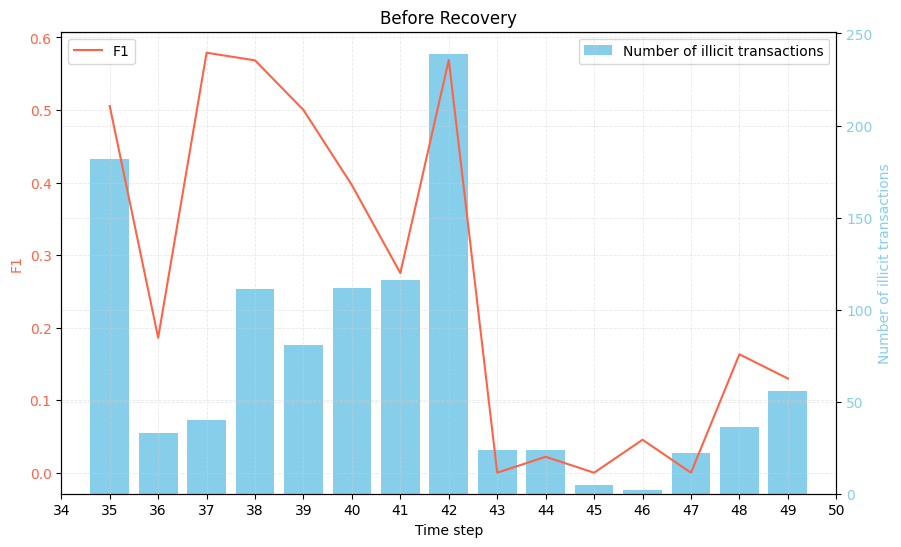

In [27]:
# test 
# test results on each time step of the test set and number of illicit transactions in each time step
# dict of test results on each time step and number of illicit transactions in each time step
test_results = {}

for t in range(35, 50):
    test_classified_idx = temp_node_features.loc[(temp_node_features['time_step'] == t) & (temp_node_features['class'] != 2)].index
    data_graph.test_idx = test_classified_idx
    acc, f1, precision, recall = evolvegcnh_test(evolvegcnh_model, data_graph)
    num_illicit = temp_node_features.loc[(temp_node_features['time_step'] == t) & (temp_node_features['class'] == 1)].shape[0]
    test_results[t] = [num_illicit, f1, acc, precision, recall]
    
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Changing bar color to dark blue and line color to solid orange
ax2.bar(list(test_results.keys()), [x[0] for x in test_results.values()], color='skyblue', alpha=1)
ax1.plot(list(test_results.keys()), [x[1] for x in test_results.values()], color='tomato')
ax1.set_xlim(34, 50)
# Legend
ax1.legend(['F1'], loc='upper left')
ax2.legend(['Number of illicit transactions'], loc='upper right')

ax1.set_xlabel('Time step')

# Changing y-label colors to match their corresponding plot elements
ax1.set_ylabel('F1', color='tomato')
ax2.set_ylabel('Number of illicit transactions', color='skyblue')

# Changing tick colors to match their corresponding plot elements
ax1.tick_params(axis='y', labelcolor='tomato')
ax2.tick_params(axis='y', labelcolor='skyblue')

# Show every tick number
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))

# Enhancing grid visibility
ax1.grid(True, linestyle='--', linewidth=0.6, color='lightgrey', alpha=0.5)
ax2.grid(True, linestyle='--', linewidth=0.6, color='lightgrey', alpha=0.5)

# To put ax1 (F1 line) in the front
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)

# add title
plt.title('Before Recovery')

plt.show()


## EvolveGCN evoleveh_model black market shutdown test

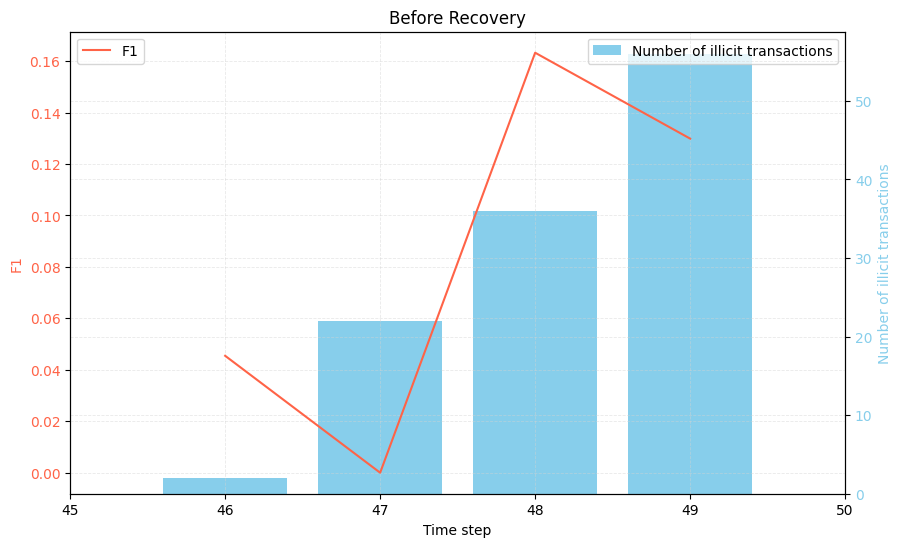

In [28]:
# test after shutdown
test_results = {}

for t in range(46, 50):
    test_classified_idx = temp_node_features.loc[(temp_node_features['time_step'] == t) & (temp_node_features['class'] != 2)].index
    data_graph.test_idx = test_classified_idx
    acc, f1, precision, recall = evolvegcnh_test(evolvegcnh_model, data_graph)
    num_illicit = temp_node_features.loc[(temp_node_features['time_step'] == t) & (temp_node_features['class'] == 1)].shape[0]
    test_results[t] = [num_illicit, f1, acc, precision, recall]
    
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

ax2.bar(list(test_results.keys()), [x[0] for x in test_results.values()], color='skyblue', alpha=1)
ax1.plot(list(test_results.keys()), [x[1] for x in test_results.values()], color='tomato')
ax1.set_xlim(45, 50)
ax1.legend(['F1'], loc='upper left')
ax2.legend(['Number of illicit transactions'], loc='upper right')

ax1.set_xlabel('Time step')

ax1.set_ylabel('F1', color='tomato')
ax2.set_ylabel('Number of illicit transactions', color='skyblue')

ax1.tick_params(axis='y', labelcolor='tomato')
ax2.tick_params(axis='y', labelcolor='skyblue')

ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax1.grid(True, linestyle='--', linewidth=0.6, color='lightgrey', alpha=0.5)
ax2.grid(True, linestyle='--', linewidth=0.6, color='lightgrey', alpha=0.5)

ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)
plt.title('Before Recovery')

plt.show()

## EvolveGCN evoleveh_model black market shutdown recovery test

In [29]:
evolo_train_classified_idx = temp_node_features.loc[(((temp_node_features['time_step'] >= 43) & (temp_node_features['time_step'] <= 45)) | (temp_node_features['time_step'] <= 34)) & (temp_node_features['class'] != 2)].index
evolo_test_classified_idx = temp_node_features.loc[(temp_node_features['time_step'] > 45) & (temp_node_features['class'] != 2)].index

# train
data_graph.train_idx = evolo_train_classified_idx
data_graph.test_idx = evolo_test_classified_idx

num_of_nodes = data_graph.num_nodes
in_channels = data_graph.num_node_features
evolvegcnh_model = EvolveGCNHModel(num_of_nodes, in_channels, 2).to(device)

num_epochs = 500
lr = 0.001
optimizer = torch.optim.Adam(evolvegcnh_model.parameters(), lr=lr)

best_metric_list = []
max_f1 = 0

for epoch in range(num_epochs+1):
    loss = evolvegcnh_train(evolvegcnh_model, data_graph, optimizer)
    acc, f1, precision, recall = evolvegcnh_test(evolvegcnh_model, data_graph)
    # save metrics list when f1 is max
    if f1 > max_f1:
        max_f1 = f1
        best_metric_list = [acc, f1, precision, recall]
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
        ...
print(f'best: Accuracy: {best_metric_list[0]:.4f}, F1: {best_metric_list[1]:.4f}, Precision: {best_metric_list[2]:.4f}, Recall: {best_metric_list[3]:.4f}')


Epoch: 000, Loss: 20.2966, Accuracy: 0.6503, F1: 0.1222, Precision: 0.0692, Recall: 0.5259
Epoch: 010, Loss: 0.8242, Accuracy: 0.9337, F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch: 020, Loss: 1.0510, Accuracy: 0.9533, F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch: 030, Loss: 0.9532, Accuracy: 0.9537, F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch: 040, Loss: 0.5602, Accuracy: 0.9505, F1: 0.0462, Precision: 0.2143, Recall: 0.0259
Epoch: 050, Loss: 0.4538, Accuracy: 0.9533, F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch: 060, Loss: 0.2356, Accuracy: 0.9449, F1: 0.0282, Precision: 0.0769, Recall: 0.0172
Epoch: 070, Loss: 0.5622, Accuracy: 0.9525, F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch: 080, Loss: 0.5790, Accuracy: 0.9429, F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch: 090, Loss: 0.2980, Accuracy: 0.9509, F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch: 100, Loss: 0.2979, Accuracy: 0.9437, F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch: 11

Accuracy: 0.9537, F1: 0.0000, Precision: 0.0000, Recall: 0.0000


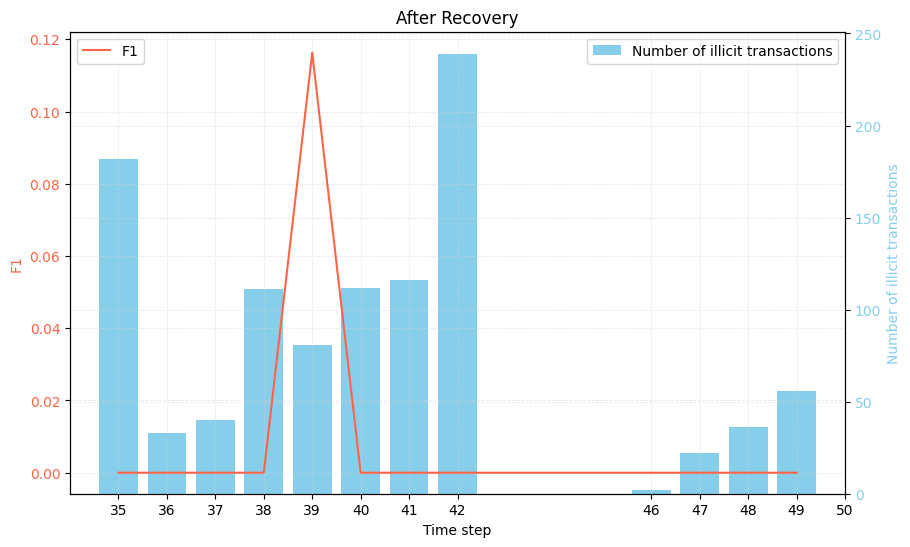

In [30]:
# test 
acc, f1, precision, recall = evolvegcnh_test(evolvegcnh_model, data_graph)
print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
# test results on each time step of the test set and number of illicit transactions in each time step
# dict of test results on each time step and number of illicit transactions in each time step
test_results = {}

for t in range(35, 50):
    test_classified_idx = temp_node_features.loc[(temp_node_features['time_step'] == t) & (temp_node_features['class'] != 2)].index
    data_graph.test_idx = test_classified_idx
    acc, f1, precision, recall = evolvegcnh_test(evolvegcnh_model, data_graph)
    num_illicit = temp_node_features.loc[(temp_node_features['time_step'] == t) & (temp_node_features['class'] == 1)].shape[0]
    test_results[t] = [num_illicit, f1, acc, precision, recall]


test_list = [35, 36, 37, 38, 39, 40, 41, 42, 46, 47, 48, 49, 50]
# remove the key-value pairs with key not in test_list
test_results = {key:val for key, val in test_results.items() if key in test_list}

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Changing bar color to dark blue and line color to solid orange
ax2.bar(list(test_results.keys()), [x[0] for x in test_results.values()], color='skyblue', alpha=1)
ax1.plot(list(test_results.keys()), [x[1] for x in test_results.values()], color='tomato')
ax1.set_xlim(34, 50)
# Legend
ax1.legend(['F1'], loc='upper left')
ax2.legend(['Number of illicit transactions'], loc='upper right')

ax1.set_xlabel('Time step')

# Changing y-label colors to match their corresponding plot elements
ax1.set_ylabel('F1', color='tomato')
ax2.set_ylabel('Number of illicit transactions', color='skyblue')

# Changing tick colors to match their corresponding plot elements
ax1.tick_params(axis='y', labelcolor='tomato')
ax2.tick_params(axis='y', labelcolor='skyblue')

# Show every tick number
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))

# remove 43, 44, 45 and it's line chart and bar chart
ax1.set_xticks([35, 36, 37, 38, 39, 40, 41, 42, 46, 47, 48, 49, 50])
ax2.set_xticks([35, 36, 37, 38, 39, 40, 41, 42, 46, 47, 48, 49, 50])

# Enhancing grid visibility
ax1.grid(True, linestyle='--', linewidth=0.6, color='lightgrey', alpha=0.5)
ax2.grid(True, linestyle='--', linewidth=0.6, color='lightgrey', alpha=0.5)

# To put ax1 (F1 line) in the front
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)

# add title
plt.title('After Recovery')

plt.show()


Accuracy: 0.8824, F1: 0.0000, Precision: 0.0000, Recall: 0.0000


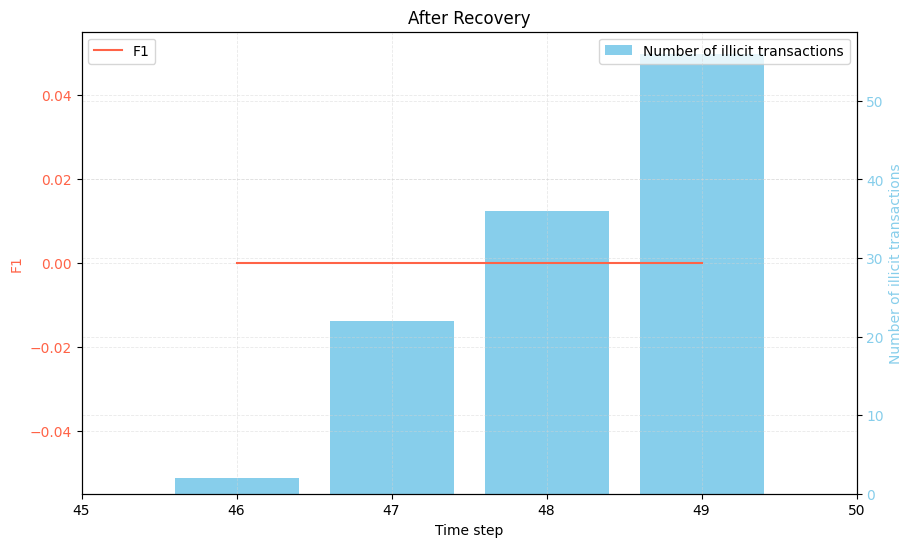

In [32]:
# test recovery
acc, f1, precision, recall = evolvegcnh_test(evolvegcnh_model, data_graph)
print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
test_results = {}

for t in range(46, 50):
    test_classified_idx = temp_node_features.loc[(temp_node_features['time_step'] == t) & (temp_node_features['class'] != 2)].index
    data_graph.test_idx = test_classified_idx
    acc, f1, precision, recall = evolvegcnh_test(evolvegcnh_model, data_graph)
    num_illicit = temp_node_features.loc[(temp_node_features['time_step'] == t) & (temp_node_features['class'] == 1)].shape[0]
    test_results[t] = [num_illicit, f1, acc, precision, recall]
    
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

ax2.bar(list(test_results.keys()), [x[0] for x in test_results.values()], color='skyblue', alpha=1)
ax1.plot(list(test_results.keys()), [x[1] for x in test_results.values()], color='tomato')
ax1.set_xlim(45, 50)
ax1.legend(['F1'], loc='upper left')
ax2.legend(['Number of illicit transactions'], loc='upper right')

ax1.set_xlabel('Time step')

ax1.set_ylabel('F1', color='tomato')
ax2.set_ylabel('Number of illicit transactions', color='skyblue')

ax1.tick_params(axis='y', labelcolor='tomato')
ax2.tick_params(axis='y', labelcolor='skyblue')

ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax1.grid(True, linestyle='--', linewidth=0.6, color='lightgrey', alpha=0.5)
ax2.grid(True, linestyle='--', linewidth=0.6, color='lightgrey', alpha=0.5)

ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)
plt.title('After Recovery')

plt.show()